<a href="https://colab.research.google.com/github/BMClab/papers/blob/master/h2a_age_spt/notebooks/h2a_age_spt_comf_speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A test of the joint torque redistribution hypothesis

> [Laboratory of Biomechanics and Motor Control](http://pesquisa.ufabc.edu.br/bmclab/)  
> Federal University of ABC, Brazil

## Introduction

This notebook reports the statistical results of testing two hypotheses:  
1. Aging is associated to a redistribution of joint torques and powers during gait (proposed by DeVita and Hortobagyi in 2000).  
2. Such age-related redistribution of joint torques and powers during gait is due to differences in spatio-temporal variables, such as step length, cadence and speed (proposed by Lim, Lin and Pandy in 2013).

The experimental data are taken from an open dataset (Fukuchi et al., 2018). This dataset contains raw and processed data from standard 3d gait analysis of healthy volunteers walking in both overground and treadmill in a range of speeds.  

We replicated similar conditions of the DeVita and Hortobagyi (2000) study:  
  - Two age categories (Young adults and Older adults).  
  - All subjects walking at a self-selected comfortable speed on a treadmill (for a more reliable control of speed).

Subjects at a speed similar ($\pm$10%) of the comfortable speed of older adults

The discrete variables were calculated according to reported by DeVita and Hortobagyi (2000).  

## Python setup

In [1]:
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.subplots import make_subplots
import plotly.express as px
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm

if "google.colab" in sys.modules:
    %pip install -q pingouin
    %pip install -q watermark

import pingouin as pg

%load_ext watermark

### Environment

In [2]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.1)
#palette = sns.color_palette(palette='Set1')  # tab10
#palette[0], palette[1] = palette[1], palette[0]
#sns.set_palette(palette=palette)
pd.set_option('display.precision', 3)  # number of decimal places for the environment
pd.set_option('future.no_silent_downcasting', True)

# Run bootstrap (very slow)
run_bootstrap = False
# number of bootstraps to be performed
n_boots = 100
# significance level
alpha = 0.05
# colors
#colors = sns.color_palette()
colors = plotly.colors.DEFAULT_PLOTLY_COLORS
colors2 = [tuple(np.fromstring(c[4:-1], sep=',')/255) for c in colors]

%watermark -u -t -d -m -v --iversions

Last updated: 2025-12-13 00:22:35

Python implementation: CPython
Python version       : 3.12.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.6.105+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

pandas     : 2.2.2
numpy      : 2.0.2
sys        : 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
pingouin   : 0.5.5
statsmodels: 0.14.6
tqdm       : 4.67.1
plotly     : 5.24.1
matplotlib : 3.10.0
seaborn    : 0.13.2



### Custom functions

In [3]:
def ttest(df, feature, group, levels=None, alpha=alpha):
    """t-test statistcs for dataframe columns using the pingouin library.
    """
    stats = []
    if levels is None:
        levels = df[group].unique()
    if len(levels) != 2:
        raise Exception('Incorrect number of levels: {}'.format(len(levels)))
    for f in feature:
        x = df[df[group] == levels[0]][f]
        y = df[df[group] == levels[1]][f]
        stat = pg.ttest(x, y, confidence=1-alpha)
        stat.index = [f]
        diff = np.round(100 * (np.mean(x) - np.mean(y)) / np.mean(y), 0)
        diff = pd.DataFrame(data=diff, index=[f], columns=['%diff'], dtype=int)
        stat = pd.concat([stat, diff], axis=1)
        stats.append(stat)

    stats = [df.dropna(axis=1, how='all') for df in stats]
    stats = pd.concat(stats, axis=0)
    stats.drop(columns=['alternative', 'BF10', 'power'], inplace=True)
    stats.index.name = '{}-{}'.format(*levels)
    display(stats.style.format({'p-val': '{:.3f}'}).apply(sig_red, subset='p-val', axis=1))
    return stats


def normtest(df, feature, group, alpha=alpha):
    """Normality test for dataframe columns using the pingouin library.
    """
    levels = df[group].unique()
    for level in levels:
        test = pg.normality(df[df[group] == level][feature], method='normaltest')
        test.index.name = level
        display(test.style.format({'pval': '{:.3f}'}).apply(sig_red, axis=1))


def normality(df):
    """Get the p-val of the normality test using the pingouin library.
    """
    return pg.normality(df)['pval']


def describe(df, feature, group, stat=['count', 'mean', 'std', 'min', 'max', normality]):
    """Descriptive statistics for dataframe columns.
    """
    col = [('Young', 'normality'), ('Older', 'normality')]
    x = df.groupby(group)[feature].agg(stat).stack(future_stack=True).transpose().style.apply(sig_red, subset=col)
    display(x)
    return x


def sig_red(col, alpha=alpha):
    """Returns string 'color: red' for `col` < `alpha`, black otherwise.
    """
    col = np.array([(float(x[1:]) if isinstance(x, str) else float(x))
                    if len(str(x)) else np.nan for x in col])

    is_sig = col < alpha
    return ['color: red' if x else 'color: black' for x in is_sig]


def regression(fit_ml, fit_re, names):
    """Get results from linear regression as list.

    results = ['Response', 'Coef', 'CI', 'p', 'Coef', 'CI', 'p', Coef', 'CI', 'p',
               'llf', 'AIC', 'R2']
    """
    # print(fit_re.model.exog_names)
    if names is None:
        names = fit_re.model.exog_names[1:]
    results = [np.nan]*(1 + len(names)*3 + 3)
    # response
    results[ 0] = fit_re.model.endog_names
    # log-likelihood function
    results[-3] = '{:.1f}'.format(fit_ml.llf)
    # Akaike information criterion
    results[-2] = '{:.1f}'.format(fit_ml.aic)
    # marginal R2, proportion of variance explained by the fixed factor(s) alone
    results[-1] = '{:.2f}'.format(np.corrcoef(fit_re.model.endog, fit_re.predict())[0, 1]**2)
    # conditional R2, proportion of variance explained by both the fixed and random factors
    #results[-1] = np.round(np.corrcoef(fit_re.model.endog, fit_re.fittedvalues)[0, 1]**2, 2)
    for name in fit_re.model.exog_names[1:]:
        idx = names.index(name)
        # fitted fixed-effects coefficients
        results[3*idx+1] = '{:.2f}'.format(fit_re.params[name])
        # confidence interval for the fitted parameters
        ci = fit_re.conf_int().loc[name].values
        results[3*idx+2] = '[{:.2f}, {:.2f}]'.format(ci[0], ci[1])
        # two-tailed p values for the t-stats of the params
        if fit_re.pvalues[name] < 0.0001:
            results[3*idx+3] = '< 0.0001'
        else:
            results[3*idx+3] = '{:.4f}'.format(fit_re.pvalues[name])

    return results


def runmodels(data, predictors, responses, groups, names, mixed=True, show=True):
    """Run OLS or mixed linear regression models.
    """
    fit_ml = []
    fit_re = []
    models = []
    i = 0
    print('Running regression models...')
    for response in responses:
        for predictor in predictors:
            eq = '{} ~ {}'.format(response, predictor)
            print(response, predictor)
            if mixed:
                md = smf.mixedlm(formula=eq, data=data, groups=groups)
            else:
                md = smf.ols(formula=eq, data=data)
            # use ML method to estimate AIC and llf
            fit_ml.append(md.fit(reml=False))
            # use REML method to get unbiased estimations of the coefficients
            fit_re.append(md.fit(reml=True))
            models.append(regression(fit_ml[-1], fit_re[-1], names=names))
            if mixed:
                text = 'converged' if fit_re[-1].converged else 'didn\'t converge'
            if show:
                if mixed:
                    print('Model {:2}: {} {}.'.format(i, eq, text))
                else:
                    print('Model {:2}: {}.'.format(i, eq))
                #display(fit_re[-1].summary())
            i += 1
    if show:
        print('...done.')

    return models, fit_ml, fit_re


def display_table(models, names, del_name_idx=None, filename=None):
    """Display rich table with stats from regression models.
    """
    h0, h1, h2 = ['Feature'], ['Feature'], ['Feature']
    h0.extend(['Predictor']*3*len(names))
    for name in names:
        h1.extend(name*3)
    h2.extend(['Coef', 'CI', 'p-value']*len(names))
    h0.extend(['LLF', 'AIC', 'R2'])
    h1.extend(['LLF', 'AIC', 'R2'])
    h2.extend(['LLF', 'AIC', 'R2'])
    table = pd.DataFrame(data=models)
    table.columns=[h0, h1, h2]
    table.replace({np.nan: ''}, inplace=True)
    if del_name_idx is not None:
        for col in del_name_idx:
            table = table.drop(columns=names[col], level=1)

    if filename is not None:
        try:
            table.to_csv(f'{path2}{os.sep}{filename}', sep='\t', index=False)
        except:
            print('Table not saved in the cloud.')

    table = table.style \
            .apply(sig_red, subset=[c for c in table.columns if c[-1] == 'p-value']) \
            .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

    return table


def plot_residuals(fit=None, residuals=None, kind='marginal', x=None,
                   xlabel=None, ylabel=None, alpha=0.05, hover=None):
    """Scater plot, histogram and Q-Q plot for testing residuals.

    This function generates three subplots (1x3):
    1. Scatter plot of the residuals versus predictor variables.
    2. Histogram of the residuals and the expected normal function.
    3. Q-Q plot.

    On the third plot are also shown the statistic and p-value of the
    Shapiro-Wilk test for normality. These values are also returned as output
    of the function.

    Parameters
    ----------
    fit: statsmodels regression results or None, optional (default=None)
        `fit` is a mod.fit() structure
        See https://www.statsmodels.org/stable/regression.html
        The residuals and predictor values are taken from this parameter.

    residuals: 1-D array_like or None, optional (default=None)
        The residuals to test the normality. Enter this parameter only if
        `fit` is not inputed.

    kind: {'marginal', 'conditional'}, optional (default='marginal')
        Which kind of residuals to test (only if `fit` is inputed).
        'marginal': residuals from fixed effects
        'conditional': residuals from fixed and random effects

    x: 1-D array_like or None, optional (default=None)
        The predictor values.

    xlabel: string or None, optional (default=None)
        The predictor label.

    ylabel: string or None, optional (default=None)
        The response label.

    alpha: float, optional (default=0.05)
        The significance level

    hover: tuple (string, 1-D array_like) or None, optional (default=None)
        Information to show when hovering the data in the first plot.
        See the examples.


    Returns
    -------
    statistic: float
        The statistic of the Shapiro-Wilk test for normality.
    p-value: float
        The p-value of the null-hypothesis test for normality.

    Notes
    -----
    https://www.statsmodels.org/stable/_modules/statsmodels/regression/mixed_linear_model.html
    fit.model.fit().predict() or fit.predict() only reflect
     fixed effects mean structure of the model.
    fit.model.fit().fittedvalues or fit.fittedvalues reflect the mean
     structure specified by fixed effects and predicted random effects.

    Examples
    --------
    >>> residuals = np.random.normal(loc=0.0, scale=1.0, size=1000)
    >>> plot_residuals(residuals=residuals)
    >>> residuals = np.random.lognormal(mean=1.0, sigma=0.5, size=100)
    >>> plot_residuals(residuals=residuals, xlabel= 'X', ylabel='Y')
    >>> residuals = np.random.lognormal(mean=1.0, sigma=0.5, size=10)
    >>> plot_residuals(residuals=residuals, hover=('Datum', np.arange(10)))
    """

    import numpy as np
    import scipy as sp
    import plotly
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    import plotly.figure_factory as ff

    if fit is not None:
        # fit.model.fit().predict() or fit.predict() only reflect
        #  fixed effects mean structure of the model.
        # fit.model.fit().fittedvalues or fit.fittedvalues reflect the mean
        #  structure specified by fixed effects and predicted random effects.
        if kind == 'marginal':
            residuals = fit.model.endog - fit.model.fit().predict()
        elif kind == 'conditional':
            residuals = fit.model.endog - fit.model.fit().fittedvalues
        else:
            raise ValueError("Valid options for 'kind': 'marginal' or 'conditional'.")
        x = fit.model.exog[:, 1]
    else:
        if residuals is None:
            raise ValueError('If fit is None, residuals cannot be None.')
        if x is None:
            x = np.arange(0, len(residuals))
    if xlabel is None:
        xlabel = 'Predictor'
    if ylabel is None:
        ylabel = 'Response'

    # normality of residuals test
    W, p = sp.stats.shapiro(residuals)  # Shapiro-Wilk test
    if p < 0.001:
        p_str = 'p < 0.001'
    else:
        p_str = 'p = {:.3f}'.format(p)
    # plots
    fig = make_subplots(rows=1, cols=3, horizontal_spacing=0.1,
                        subplot_titles=('Scatter plot', 'Histogram', 'Q-Q plot'))
    # scatter plot
    if hover is not None:
        label, data = hover[0], hover[1]
        template = ['<b>{}: '.format(label) + '%{customdata}</b> <br>' +
                    '{}: '.format(xlabel) + '%{x} <br>Residual: %{y} ']
        fig.add_trace(go.Scatter(x=x, y=residuals, mode='markers',
                                 marker=dict(color=colors[0]),
                                 customdata=data,
                                 hovertemplate=template[0],
                                 name=''),
                      row=1, col=1)
    else:
        fig.add_trace(go.Scatter(x=x, y=residuals, mode='markers', name='',
                                 marker=dict(color=colors[0])), row=1, col=1)
    if min(residuals)<=0 and max(residuals)>=0:
        fig.add_hline(y=0, line=dict(width=2, color='rgba(0,0,0,.5)'), row=1, col=1)
    # histogram
    fig.add_trace(go.Histogram(x=residuals, marker_color=colors[0], name='',
                               histnorm='probability density'), row=1, col=2)
    norm = ff.create_distplot([residuals], group_labels=[''],
                              curve_type='normal', show_rug=False).data[1]
    fig.add_trace(go.Scatter(x=norm['x'], y=norm['y'], mode = 'lines', name='',
                             line=dict(width=3, color=colors[1])), row=1, col=2)
    # Q-Q plot
    qq = sp.stats.probplot(residuals, dist='norm')
    qqx = np.array([qq[0][0][0], qq[0][0][-1]])
    fig.add_trace(go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers', name='',
                             marker=dict(color=colors[0])), row=1, col=3)
    fig.add_trace(go.Scatter(x=qqx, y=qq[1][1] + qq[1][0]*qqx, mode='lines', name='',
                             line=dict(width=3, color=colors[1])), row=1, col=3)
    fig.add_annotation(text='W = {:.2f}<br>{}'.format(W, p_str),
                       xref='x domain', yref='y domain', align='left', valign='top',
                       x=0.02, y=0.98, showarrow=False, row=1, col=3)
    # x and y axes properties
    fig.update_xaxes(title_text=xlabel, row=1, col=1)
    fig.update_xaxes(title_text='Residuals', row=1, col=2)
    fig.update_xaxes(title_text='Normal theoretical quantiles', row=1, col=3)
    fig.update_yaxes(title_text='Residuals', row=1, col=1)
    fig.update_yaxes(title_text='Probability density', row=1, col=2)
    fig.update_yaxes(title_text='Observed data quantiles', row=1, col=3)

    text='Normality tests for residuals of {} &times; {}'.format(ylabel, xlabel)
    fig.update_layout(showlegend=False, height=400, font_color='black',
                      title=dict(text=text, x=.5, xanchor='center', yanchor='top',
                                 font=dict(size=20)))
    fig.show()
    print(['We {}reject the null hypothesis that the residuals come from a population' +
           ' with normal distribution\n(Shapiro-Wilk test: W({}) = {:.2f}, {}).'
          ][0].format('failed to ' if p>alpha else '', len(x), W, p_str))

    return W, p


def bootstrap(df, df2, response, predictor, groups, n_boots=1000):
    """Bootstrap observations for parameter estimation of linear mixed effects model.
    """
    y_boot = np.zeros((df2.shape[0], n_boots))
    eq = '{} ~ {}'.format(response, predictor)
    for i in tqdm(range(n_boots)):
        y_boot[:, i] = smf.mixedlm(formula=eq,
                                   groups=groups,
                                   data=df.sample(n=df.shape[0], replace=True)
                                  ).fit().predict(df2)
    return y_boot


def boxplots(df, var=['Speed', 'Cadence', 'StepLength', 'H2A_M', 'H2A_I', 'H2A_W']):
    """Boxplots of variables var in df
    """
    fig, axs = plt.subplots(1, len(var), figsize=(12, 3),
                            gridspec_kw={'hspace':.1, 'wspace':.5})
    for ax, v in zip(axs, var):
        sns.boxplot(x='AgeGroup', y=v, data=df, fliersize=9, ax=ax)
        sns.swarmplot(x='AgeGroup', y=v, data=df, ax=ax, color='gray')
        ax.set_title(v)
        ax.set_ylabel('')
    plt.show()


### Dataset location

In [4]:
# file with discrete variables calculated by 'Walking speed torque  .ipynb'
path2 = f'.{os.sep}..{os.sep}data'
filename = 'h2a_comfpeed_43subs.csv'
if not os.path.isfile((path2 := Path(path2)) / filename):
    print('Dataset not found locally. It will be loaded from the GitHub repo.')
    # REMOTE
    path2 = 'https://raw.githubusercontent.com/BMClab/papers/master/h2a_age_spt/data'

print(f'Dataset location: {path2}')
filename = f'{path2}{os.sep}{filename}'

Dataset not found locally. It will be loaded from the GitHub repo.
Dataset location: https://raw.githubusercontent.com/BMClab/papers/master/h2a_age_spt/data


## Read data

In [5]:
df = pd.read_csv(filename)
df

,Subject,AgeGroup,Gender,Age,Height,Mass,BMI,LegLength,SpeedCat,SpeedComf,Speed,StepLength,Cadence,H2A_M,H2A_I,H2A_W
0,1,Young,M,25,1.725,74.30,24.970,0.890,V5,1.21,1.21,0.647,112.853,0.601,0.373,1.600
1,3,Young,M,33,1.793,75.85,23.594,0.940,V6,0.98,1.12,0.636,105.882,0.521,0.335,1.197
2,4,Young,M,24,1.840,61.05,18.032,0.940,V5,1.30,1.30,0.665,118.033,0.578,0.400,1.159
3,5,Young,M,28,1.709,77.55,26.552,0.860,V5,1.29,1.29,0.648,119.601,0.589,0.366,1.077
4,6,Young,M,25,1.742,83.15,27.401,0.910,V5,1.28,1.28,0.664,115.200,0.552,0.353,0.840
5,7,Young,F,24,1.575,71.75,28.924,0.840,V6,1.10,1.27,0.640,118.812,0.375,0.240,0.890
6,8,Young,M,36,1.825,64.00,19.216,0.970,V4,1.38,1.17,0.643,109.589,0.468,0.354,0.795
7,9,Young,F,25,1.691,61.25,21.420,0.840,V5,1.17,1.17,0.616,113.565,0.493,0.344,1.195
8,10,Young,F,31,1.622,61.70,23.452,0.870,V4,1.37,1.17,0.595,117.455,0.455,0.301,1.023
9,11,Young,M,32,1.920,77.55,21.037,0.980,V5,1.31,1.31,0.703,111.455,0.464,0.296,0.614


## Descriptive statistics

Data visualization with pair plots and histograms for the main variables.

In [6]:
display(df.drop_duplicates(subset='Subject', inplace=False)[
        ['Subject', 'AgeGroup', 'Gender']].groupby(['AgeGroup', 'Gender']).count().T)

AgeGroup Older     Young    
Gender       F   M     F   M
Subject      9  12     8  14

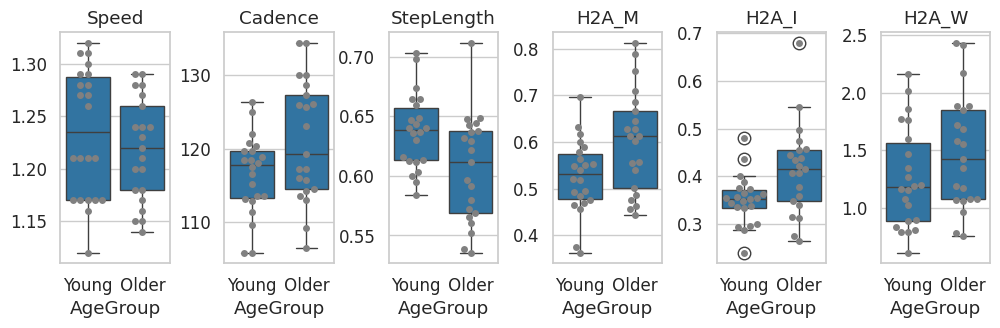

In [7]:
var = ['Age', 'Height', 'Mass', 'BMI', 'LegLength', 'Speed', 'StepLength', 'Cadence',
       'H2A_M', 'H2A_I', 'H2A_W']
describe(df, feature=var, group='AgeGroup');
boxplots(df)

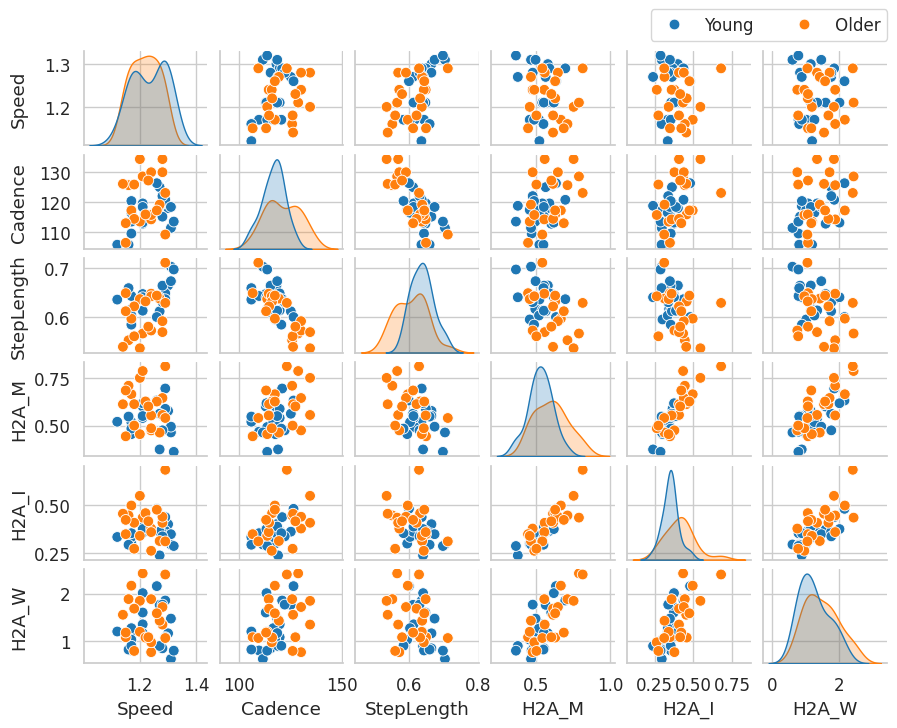

In [8]:
g = sns.pairplot(df, vars=['Speed', 'Cadence', 'StepLength', 'H2A_M', 'H2A_I', 'H2A_W'],
                 diag_kind='auto', hue='AgeGroup', plot_kws={'s':60}, height=1.2, aspect=1.1)
handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc='upper right', ncol=2,
             bbox_to_anchor=(1, 1.02), bbox_transform=plt.gcf().transFigure)
g.fig.subplots_adjust(left=.1, right=.99, bottom = 0.1, top=.95, hspace=.1, wspace=.1)
g.fig.align_ylabels(g.axes[:, 0])
plt.show()

## Inferential statistics

### Correlation between variables

In [9]:
var = ['Speed', 'Cadence', 'StepLength', 'H2A_M', 'H2A_I', 'H2A_W']
corr = df[df['AgeGroup']=='Young'][var].rcorr(stars=True)
display(corr.style.set_caption('Correlation matrix for group Young'))
corr = df[df['AgeGroup']=='Older'][var].rcorr(stars=True)
display(corr.style.set_caption('Correlation matrix for group Older'))

,Speed,Cadence,StepLength,H2A_M,H2A_I,H2A_W
Speed,-,*,**,,,
Cadence,0.467,-,*,,*,*
StepLength,0.57,-0.455,-,,,
H2A_M,0.003,0.227,-0.209,-,***,**
H2A_I,0.1,0.454,-0.312,0.83,-,***
H2A_W,0.109,0.525,-0.368,0.648,0.683,-


,Speed,Cadence,StepLength,H2A_M,H2A_I,H2A_W
Speed,-,,,,,
Cadence,0.17,-,***,,,
StepLength,0.398,-0.833,-,,,
H2A_M,-0.047,0.371,-0.369,-,***,***
H2A_I,0.047,0.336,-0.293,0.83,-,***
H2A_W,0.033,0.216,-0.195,0.771,0.689,-


In [10]:
# A more detailed correlation table:
d = df[df['AgeGroup']=='Young'][var].pairwise_corr(method='pearson')
display(d.style.format({'p-unc': '{:.3f}'}).apply(sig_red, subset=['p-unc'])
        .set_caption('Pairwise correlation for group Young'))
d = df[df['AgeGroup']=='Older'][var].pairwise_corr(method='pearson')
display(d.style.format({'p-unc': '{:.3f}'}).apply(sig_red, subset=['p-unc'])
        .set_caption('Pairwise correlation for group Older'))

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,Speed,Cadence,pearson,two-sided,22,0.466785,[0.06 0.74],0.029,2.517,0.613343
1,Speed,StepLength,pearson,two-sided,22,0.570457,[0.2 0.8],0.006,9.739,0.820904
2,Speed,H2A_M,pearson,two-sided,22,0.003206,[-0.42 0.42],0.989,0.264,0.049342
3,Speed,H2A_I,pearson,two-sided,22,0.100030,[-0.34 0.5 ],0.658,0.29,0.072408
4,Speed,H2A_W,pearson,two-sided,22,0.109250,[-0.33 0.51],0.628,0.295,0.076961
5,Cadence,StepLength,pearson,two-sided,22,-0.454501,[-0.74 -0.04],0.034,2.206,0.586601
6,Cadence,H2A_M,pearson,two-sided,22,0.226901,[-0.22 0.59],0.310,0.429,0.176077
7,Cadence,H2A_I,pearson,two-sided,22,0.454391,[0.04 0.74],0.034,2.204,0.586362
8,Cadence,H2A_W,pearson,two-sided,22,0.525370,[0.13 0.78],0.012,5.103,0.736671
9,StepLength,H2A_M,pearson,two-sided,22,-0.209226,[-0.58 0.23],0.350,0.399,0.156021


,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,Speed,Cadence,pearson,two-sided,21,0.170436,[-0.28 0.56],0.460,0.349,0.114976
1,Speed,StepLength,pearson,two-sided,21,0.398200,[-0.04 0.71],0.074,1.21,0.446170
2,Speed,H2A_M,pearson,two-sided,21,-0.046861,[-0.47 0.39],0.840,0.275,0.054026
3,Speed,H2A_I,pearson,two-sided,21,0.046555,[-0.39 0.47],0.841,0.275,0.053964
4,Speed,H2A_W,pearson,two-sided,21,0.032551,[-0.4 0.46],0.889,0.273,0.051570
5,Cadence,StepLength,pearson,two-sided,21,-0.833038,[-0.93 -0.63],0.000,7400.271,0.999324
6,Cadence,H2A_M,pearson,two-sided,21,0.370602,[-0.07 0.69],0.098,0.975,0.391454
7,Cadence,H2A_I,pearson,two-sided,21,0.335544,[-0.11 0.67],0.137,0.763,0.326770
8,Cadence,H2A_W,pearson,two-sided,21,0.215594,[-0.24 0.59],0.348,0.409,0.157067
9,StepLength,H2A_M,pearson,two-sided,21,-0.368688,[-0.69 0.07],0.100,0.961,0.387773


### Test for difference between groups' characteristics

In [11]:
var = ['Age', 'Height', 'Mass', 'BMI', 'LegLength']
stats = ttest(df, var, 'AgeGroup', levels=['Older', 'Young'])

,T,dof,p-val,CI95%,cohen-d,%diff
Older-Young,,,,,,
Age,25.447390,40.196112,0.000,[33.26 39. ],7.780884,130
Height,-2.196103,40.275372,0.034,[-0.14 -0.01],0.671371,-4
Mass,-0.385626,38.362342,0.702,[-9.22 6.27],0.118253,-2
BMI,1.185390,40.099426,0.243,[-0.91 3.49],0.359948,5
LegLength,-1.215326,38.449386,0.232,[-0.07 0.02],0.372640,-3


### Test for difference between groups' spatio-temporal variables

In [12]:
var = ['Speed', 'Cadence', 'StepLength']
stats = ttest(df, var, 'AgeGroup', levels=['Older', 'Young'])

,T,dof,p-val,CI95%,cohen-d,%diff
Older-Young,,,,,,
Speed,-0.946575,39.936940,0.350,[-0.05 0.02],0.287341,-1
Cadence,2.148730,34.479791,0.039,[0.25 8.85],0.661667,4
StepLength,-2.630706,35.760227,0.012,[-0.06 -0.01],0.809062,-5


### Test for difference between groups' joint torque and power variables

In [13]:
var = ['H2A_M', 'H2A_I', 'H2A_W']
stats = ttest(df, var, 'AgeGroup', levels=['Older', 'Young'])

,T,dof,p-val,CI95%,cohen-d,%diff
Older-Young,,,,,,
H2A_M,2.537880,36.328319,0.016,[0.01 0.13],0.780057,14
H2A_I,2.650075,30.360937,0.013,[0.01 0.11],0.819178,18
H2A_W,1.545212,39.789220,0.130,[-0.07 0.51],0.472843,18


## Regression models

The predictors are Age (as categorical), cadence, step length.  
The response variables are H2A_M, H2A_I and H2A_W.

### Data normalization

Normalize data for satisfying linear regression assumptions, but this step has no effect on the final results.

In [14]:
dfraw = df.copy(deep=True)
var = ['Height', 'Mass', 'BMI', 'LegLength', 'Speed', 'Cadence', 'StepLength',
       'H2A_M', 'H2A_I', 'H2A_W']
# Standardization (mean 0, variance 1)
df[var] = df[var].apply(lambda x: (x-x.mean())/x.std(), axis=0)

#### Replace letters by numeric values because it's easier to identify the effect  
E.g.: {'Y': 0, 'O': 1} implies that if there is an effect of Age and its coefficient (slope) is positive, it means that the response increases for older subjects and decreases for young subjects. Internally the letters were replaced by numbers anyway but we didn't know the order.

In [15]:
df['AgeGroup'] = df['AgeGroup'].replace({'Young': 0, 'Older': 1}).astype(str)
df['Gender'] = df['Gender'].replace({'F': 0, 'M': 1}).astype(str)

### Age, Step Length, Cadence and Speed (Step Length × Cadence)

Of note, the variable Speed is equal to the product between the variables Step Length and Cadence.

In [16]:
features = ['H2A_M', 'H2A_I', 'H2A_W']
labels   = ['H2A_M', 'H2A_I', 'H2A_W']

predictors = ['C(AgeGroup)',
              'StepLength',
              'Cadence',
              'Speed',
              'C(AgeGroup) + StepLength',
              'C(AgeGroup) + Cadence',
              'C(AgeGroup) + Speed',
              'C(AgeGroup) + StepLength + Cadence',
              'StepLength + Cadence',
              'StepLength + Cadence + Speed',
              'C(AgeGroup) + StepLength + Cadence + Speed'
             ]
groups = df['Subject']

names = ['C(AgeGroup)[T.1]', 'StepLength', 'Cadence', 'Speed']
models, fit_ml, fit_re = runmodels(df, predictors, features, groups=None, names=names, mixed=False)

Running regression models...
H2A_M C(AgeGroup)
Model  0: H2A_M ~ C(AgeGroup).
H2A_M StepLength
Model  1: H2A_M ~ StepLength.
H2A_M Cadence
Model  2: H2A_M ~ Cadence.
H2A_M Speed
Model  3: H2A_M ~ Speed.
H2A_M C(AgeGroup) + StepLength
Model  4: H2A_M ~ C(AgeGroup) + StepLength.
H2A_M C(AgeGroup) + Cadence
Model  5: H2A_M ~ C(AgeGroup) + Cadence.
H2A_M C(AgeGroup) + Speed
Model  6: H2A_M ~ C(AgeGroup) + Speed.
H2A_M C(AgeGroup) + StepLength + Cadence
Model  7: H2A_M ~ C(AgeGroup) + StepLength + Cadence.
H2A_M StepLength + Cadence
Model  8: H2A_M ~ StepLength + Cadence.
H2A_M StepLength + Cadence + Speed
Model  9: H2A_M ~ StepLength + Cadence + Speed.
H2A_M C(AgeGroup) + StepLength + Cadence + Speed
Model 10: H2A_M ~ C(AgeGroup) + StepLength + Cadence + Speed.
H2A_I C(AgeGroup)
Model 11: H2A_I ~ C(AgeGroup).
H2A_I StepLength
Model 12: H2A_I ~ StepLength.
H2A_I Cadence
Model 13: H2A_I ~ Cadence.
H2A_I Speed
Model 14: H2A_I ~ Speed.
H2A_I C(AgeGroup) + StepLength
Model 15: H2A_I ~ C(AgeGrou

In [17]:
names = [['Age'], ['StepLength'], ['Cadence'], ['Speed']]
display_table(models, names, filename='h2a_age_spt_comfSpeed.csv')

Table not saved in the cloud.


In [18]:
df['AgeGroup'] = df['AgeGroup'].replace({'0': 'Young', '1': 'Older'}).astype(str)

def scatter_plot(df, var):
    fig = px.scatter(df, x='StepLength', y=var, color='AgeGroup', trendline='ols',
                     hover_data=['Subject', 'StepLength', 'Cadence', 'SpeedComf'],
                     labels={'Speed':''}, width=800, height=300)
    fig.update_layout(margin=dict(l=50, r=20, t=20, b=0),
                      legend=dict(yanchor='top', y=0.95, xanchor='left', x=0.05))
    fig.show()
    fig = px.scatter(df, x='Cadence', y=var, color='AgeGroup', trendline='ols',
                     hover_data=['Subject', 'StepLength', 'Cadence', 'SpeedComf'],
                     width=800, height=300)
    fig.update_layout(margin=dict(l=50, r=20, t=10, b=40), showlegend=False)
    fig.show()

In [19]:
scatter_plot(df, 'H2A_M')

In [20]:
scatter_plot(df, 'H2A_I')

In [21]:
scatter_plot(df, 'H2A_W')

### Test of the residuals

In [22]:
plot_residuals(fit=fit_re[1], kind='marginal', xlabel= 'Step Length', ylabel='H2A_M',
               hover=('Subject', df['Subject']));
plot_residuals(fit=fit_re[12], kind='marginal', xlabel= 'Step Length', ylabel='H2A_I',
               hover=('Subject', df['Subject']));
plot_residuals(fit=fit_re[23], kind='marginal', xlabel= 'Step Length', ylabel='H2A_W',
               hover=('Subject', df['Subject']));

We failed to reject the null hypothesis that the residuals come from a population with normal distribution
(Shapiro-Wilk test: W(43) = 0.97, p = 0.450).


We reject the null hypothesis that the residuals come from a population with normal distribution
(Shapiro-Wilk test: W(43) = 0.89, p < 0.001).


We failed to reject the null hypothesis that the residuals come from a population with normal distribution
(Shapiro-Wilk test: W(43) = 0.97, p = 0.223).


In [23]:
plot_residuals(fit=fit_re[2], kind='marginal', xlabel= 'Cadence', ylabel='H2A_M',
               hover=('Subject', df['Subject']));
plot_residuals(fit=fit_re[13], kind='marginal', xlabel= 'Cadence', ylabel='H2A_I',
               hover=('Subject', df['Subject']));
plot_residuals(fit=fit_re[24], kind='marginal', xlabel= 'Cadence', ylabel='H2A_W',
               hover=('Subject', df['Subject']));

We failed to reject the null hypothesis that the residuals come from a population with normal distribution
(Shapiro-Wilk test: W(43) = 0.99, p = 0.966).


We reject the null hypothesis that the residuals come from a population with normal distribution
(Shapiro-Wilk test: W(43) = 0.93, p = 0.009).


We failed to reject the null hypothesis that the residuals come from a population with normal distribution
(Shapiro-Wilk test: W(43) = 0.98, p = 0.523).


## References
 - P. DeVita, T. Hortobagyi, Age causes a redistribution of joint torques  and powers during gait, Journal of Applied Physiology. 88 (2000) 1804–1811. https://doi.org/10.1152/jappl.2000.88.5.1804.    
 - Y.P. Lim, Y.-C. Lin, M.G. Pandy, Muscle function during gait is invariant to age when walking speed is controlled, Gait Posture. 38 (2013) 253–259.   
 - C.A. Fukuchi, R.K. Fukuchi, M. Duarte, A public dataset of overground and treadmill walking kinematics and kinetics in healthy individuals, PeerJ. 6 (2018) e4640. https://doi.org/10.7717/peerj.4640.  